In [1]:
import os
import sys
import time
import yaml
import pandas as pd
import numpy as np
import re

with open('../../config.local.yaml', 'r') as f:
    local_config = yaml.safe_load(f)

LOCAL_PATH = local_config['LOCAL_PATH']

sys.path.append(os.path.join(LOCAL_PATH, "src/python"))

import data_tools as dt
from utils import parse_casenum
from llm import get_embeddings

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from IPython.core.display import HTML
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

rng = np.random.default_rng(12898)

N_CLUSTERS = 3


c:\Users\ekung\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dfa = dt.get_agenda_items(verbose=False)

In [3]:
# Get the agenda item embeddings
texts = dfa['project_summary'].tolist()
embeddings = get_embeddings(texts)

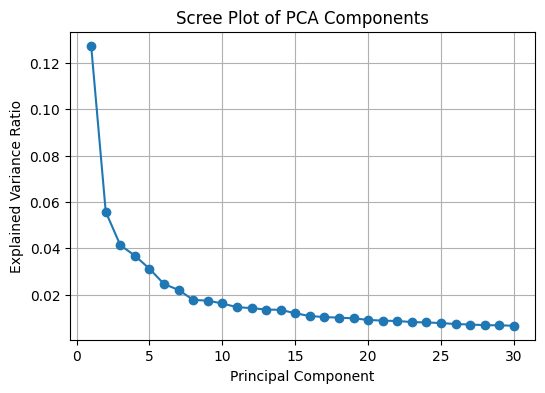

In [4]:
# PCA scree plot
pca = PCA()
pca.fit(embeddings)
explained_variance = pca.explained_variance_ratio_[0:30]
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Scree Plot of PCA Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.show()


In [5]:
# Reduce embeddings to 10 dimensions
pca = PCA(n_components=10)
embeddings_reduced = pca.fit_transform(embeddings)

In [6]:
# Cluster into 3 clusters using kmeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
kmeans.fit(embeddings_reduced)
dfa['cluster'] = kmeans.labels_
dfa['cluster'].value_counts()

cluster
0    543
1    118
2     69
Name: count, dtype: int64

In [7]:
# Show random examples from each cluster
for cluster in dfa['cluster'].unique():
    print(f"Cluster {cluster}:")
    cluster_items = dfa[dfa['cluster'] == cluster]
    sample_items = cluster_items.sample(3)
    for idx, row in sample_items.iterrows():
        print("---")
        print(row['project_summary'])
    print("======")

Cluster 0:
---
The proposed project involves the demolition of two existing structures and part of the rear of two other structures, along with an associated surface parking lot. In their place, a new thirteen-story, 201,880-square-foot mixed-use building will be constructed. This building will include 240 dwelling units, with 27 units designated for Very Low-Income households. The building will have a maximum height of 155 feet and include two subterranean levels of parking with 108 vehicular spaces and 166 bicycle spaces. The project will maintain 27,881 square feet of existing commercial space and provide 25,500 square feet of open space, including a courtyard, community room, roof deck, and private balconies. The requested actions include a Sustainable Communities Environmental Assessment, Density Bonus Compliance Review with Off-Menu Incentives and Waivers, a Main Conditional Use Permit for alcohol sales, a Site Plan Review, and a Waiver of Dedications and Improvements.
---
The pr

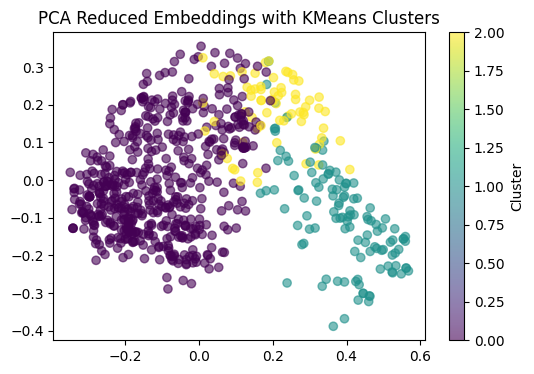

In [8]:
# Scatter plot colored by cluster
plt.figure(figsize=(6, 4))
plt.scatter(
    embeddings_reduced[:, 0], 
    embeddings_reduced[:, 1], 
    c = kmeans.labels_,
    alpha=0.6
)
plt.title('PCA Reduced Embeddings with KMeans Clusters')
plt.colorbar(label='Cluster')
plt.show()

In [9]:
df_new = dfa[['date', 'item_no', 'title', 'project_summary', 'cluster']].copy()
new_cols = [f'd{k}' for k in range(embeddings_reduced.shape[1])]
df_new = pd.concat([df_new, pd.DataFrame(embeddings_reduced, columns=new_cols)], axis=1)
df_new.to_csv(
    os.path.join(LOCAL_PATH, 'intermediate_data/cpc', 'agenda_item_with_embeddings.csv'),
    index=False,
    header=True
)

In [10]:
# create a dataframe with the cluster centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=new_cols)
centroids['cluster'] = range(N_CLUSTERS)
centroids = centroids[['cluster'] + [col for col in centroids.columns if col != 'cluster']]
centroids.to_csv(
    os.path.join(LOCAL_PATH, 'intermediate_data/cpc', 'cluster_centroids.csv'),
    index=False,
    header=True
)